In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle

In [ ]:
!kaggle datasets download -d theblackmamba31/landscape-image-colorization

Dataset URL: https://www.kaggle.com/datasets/theblackmamba31/landscape-image-colorization
License(s): unknown
 65% 125M/192M [00:00<00:00, 1.31GB/s]
100% 192M/192M [00:00<00:00, 843MB/s] 


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/landscape-image-colorization.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
import os
import numpy as np
from PIL import Image
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, Model
import matplotlib.pyplot as plt

In [ ]:
# Configs
IMG_SIZE = (256, 256)
BATCH_SIZE = 32
COLOR_DIR = './landscape Images/color'
GRAY_DIR = './landscape Images/gray'
EPOCHS = 15

In [ ]:
# Load and preprocess images
def load_and_preprocess(fname):
    color_path = os.path.join(COLOR_DIR, fname)
    gray_path = os.path.join(GRAY_DIR, fname)

    color_img = Image.open(color_path).convert("RGB").resize(IMG_SIZE)
    gray_img = Image.open(gray_path).convert("L").resize(IMG_SIZE)

    color_array = np.array(color_img).astype(np.float32) / 255.0
    gray_array = np.expand_dims(np.array(gray_img).astype(np.float32) / 255.0, axis=-1)

    return gray_array, color_array

all_filenames = sorted(os.listdir(COLOR_DIR))
train_files, test_files = train_test_split(all_filenames, test_size=0.2, random_state=42)

def tf_dataset(file_list):
    def generator():
        for fname in file_list:
            yield load_and_preprocess(fname)

    return tf.data.Dataset.from_generator(
        generator,
        output_signature=(
            tf.TensorSpec(shape=(256, 256, 1), dtype=tf.float32),
            tf.TensorSpec(shape=(256, 256, 3), dtype=tf.float32),
        )
    ).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_ds = tf_dataset(train_files)
test_ds = tf_dataset(test_files)

In [ ]:
def build_color_autoencoder():
    inputs = tf.keras.Input(shape=(256, 256, 1))

    # Encoder
    d1 = layers.Conv2D(64, 3, strides=2, padding='same', activation='relu')(inputs)
    d2 = layers.Conv2D(128, 3, strides=2, padding='same', activation='relu')(d1)
    d3 = layers.Conv2D(256, 3, strides=2, padding='same', activation='relu')(d2)
    d4 = layers.Conv2D(512, 3, strides=2, padding='same', activation='relu')(d3)

    # Decoder
    u1 = layers.Conv2DTranspose(256, 3, strides=2, padding='same', activation='relu')(d4)
    u1_cat = layers.Concatenate()([u1, d3])

    u2 = layers.Conv2DTranspose(128, 3, strides=2, padding='same', activation='relu')(u1_cat)
    u2_cat = layers.Concatenate()([u2, d2])

    u3 = layers.Conv2DTranspose(64, 3, strides=2, padding='same', activation='relu')(u2_cat)
    u3_cat = layers.Concatenate()([u3, d1])

    outputs = layers.Conv2DTranspose(3, 3, strides=2, padding='same', activation='sigmoid')(u3_cat)

    return Model(inputs, outputs, name="color_autoencoder")


model = build_color_autoencoder()

In [ ]:
model.summary()

Model: "color_autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_15      │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_60 (Conv2D)  │ (None, 128, 128,  │        640 │ input_layer_15[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_61 (Conv2D)  │ (None, 64, 64,    │     73,856 │ conv2d_60[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_62 (Conv2D)  │ (None, 32, 32,    │    295,168 │ conv2d_61[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_63 (Conv2D)  │ (None, 16, 16,    │  1,180,160 │ conv2d_62[0][0]   │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_20 │ (None, 32, 32,    │  1,179,904 │ conv2d_63[0][0]   │
│ (Conv2DTranspose)   │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_17      │ (None, 32, 32,    │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 512)              │            │ conv2d_62[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_21 │ (None, 64, 64,    │    589,952 │ concatenate_17[0… │
│ (Conv2DTranspose)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_18      │ (None, 64, 64,    │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 256)              │            │ conv2d_61[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_22 │ (None, 128, 128,  │    147,520 │ concatenate_18[0… │
│ (Conv2DTranspose)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_19      │ (None, 128, 128,  │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 128)              │            │ conv2d_60[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_23 │ (None, 256, 256,  │      3,459 │ concatenate_19[0… │
│ (Conv2DTranspose)   │ 3)                │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,470,659 (13.24 MB)

 Trainable params: 3,470,659 (13.24 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(optimizer='adam', loss='mse',metrics=['accuracy'])

In [ ]:
# Train the model
history = model.fit(train_ds, validation_data=test_ds, epochs=EPOCHS)

Epoch 1/15
    179/Unknown 59s 225ms/step - accuracy: 0.3331 - loss: 0.0396

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


179/179 ━━━━━━━━━━━━━━━━━━━━ 72s 297ms/step - accuracy: 0.3332 - loss: 0.0395 - val_accuracy: 0.3069 - val_loss: 0.0096
Epoch 2/15


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


178/179 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - accuracy: 0.3912 - loss: 0.0093

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


179/179 ━━━━━━━━━━━━━━━━━━━━ 39s 216ms/step - accuracy: 0.3914 - loss: 0.0092 - val_accuracy: 0.4168 - val_loss: 0.0075
Epoch 3/15


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


178/179 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - accuracy: 0.4372 - loss: 0.0077

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


179/179 ━━━━━━━━━━━━━━━━━━━━ 39s 216ms/step - accuracy: 0.4373 - loss: 0.0077 - val_accuracy: 0.4262 - val_loss: 0.0071
Epoch 4/15


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


178/179 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - accuracy: 0.4638 - loss: 0.0070

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


179/179 ━━━━━━━━━━━━━━━━━━━━ 39s 216ms/step - accuracy: 0.4638 - loss: 0.0070 - val_accuracy: 0.4502 - val_loss: 0.0066
Epoch 5/15


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


178/179 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - accuracy: 0.4724 - loss: 0.0066

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


179/179 ━━━━━━━━━━━━━━━━━━━━ 41s 218ms/step - accuracy: 0.4723 - loss: 0.0066 - val_accuracy: 0.4715 - val_loss: 0.0060
Epoch 6/15


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


178/179 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - accuracy: 0.4760 - loss: 0.0063

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


179/179 ━━━━━━━━━━━━━━━━━━━━ 40s 225ms/step - accuracy: 0.4759 - loss: 0.0063 - val_accuracy: 0.4686 - val_loss: 0.0059
Epoch 7/15


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


178/179 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.4796 - loss: 0.0062

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


179/179 ━━━━━━━━━━━━━━━━━━━━ 39s 215ms/step - accuracy: 0.4795 - loss: 0.0062 - val_accuracy: 0.4802 - val_loss: 0.0057
Epoch 8/15


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


178/179 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - accuracy: 0.4845 - loss: 0.0061

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


179/179 ━━━━━━━━━━━━━━━━━━━━ 39s 215ms/step - accuracy: 0.4844 - loss: 0.0061 - val_accuracy: 0.4864 - val_loss: 0.0057
Epoch 9/15


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


178/179 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - accuracy: 0.4886 - loss: 0.0060

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


179/179 ━━━━━━━━━━━━━━━━━━━━ 40s 222ms/step - accuracy: 0.4885 - loss: 0.0060 - val_accuracy: 0.4949 - val_loss: 0.0055
Epoch 10/15


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


178/179 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - accuracy: 0.4956 - loss: 0.0059

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


179/179 ━━━━━━━━━━━━━━━━━━━━ 40s 217ms/step - accuracy: 0.4956 - loss: 0.0059 - val_accuracy: 0.4913 - val_loss: 0.0055
Epoch 11/15


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


178/179 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - accuracy: 0.4984 - loss: 0.0058

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


179/179 ━━━━━━━━━━━━━━━━━━━━ 40s 224ms/step - accuracy: 0.4984 - loss: 0.0058 - val_accuracy: 0.4834 - val_loss: 0.0059
Epoch 12/15


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


178/179 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.5023 - loss: 0.0058

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


179/179 ━━━━━━━━━━━━━━━━━━━━ 38s 213ms/step - accuracy: 0.5023 - loss: 0.0058 - val_accuracy: 0.4807 - val_loss: 0.0059
Epoch 13/15


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


178/179 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.5064 - loss: 0.0058

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


179/179 ━━━━━━━━━━━━━━━━━━━━ 38s 214ms/step - accuracy: 0.5064 - loss: 0.0058 - val_accuracy: 0.4875 - val_loss: 0.0055
Epoch 14/15


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


178/179 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - accuracy: 0.5122 - loss: 0.0057

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


179/179 ━━━━━━━━━━━━━━━━━━━━ 40s 223ms/step - accuracy: 0.5122 - loss: 0.0057 - val_accuracy: 0.4934 - val_loss: 0.0054
Epoch 15/15


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


178/179 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - accuracy: 0.5171 - loss: 0.0056

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


179/179 ━━━━━━━━━━━━━━━━━━━━ 39s 215ms/step - accuracy: 0.5171 - loss: 0.0056 - val_accuracy: 0.5140 - val_loss: 0.0052


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


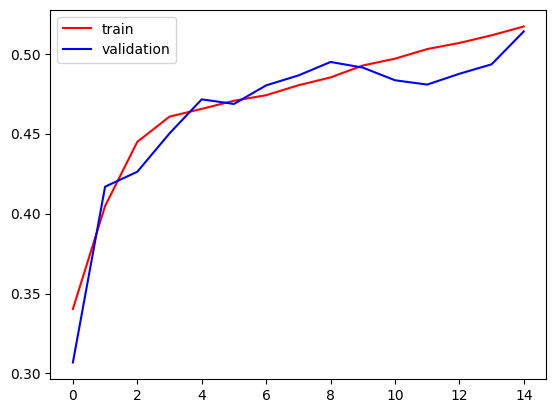

In [ ]:
plt.plot(history.history['accuracy'], color='red', label='train')
plt.plot(history.history['val_accuracy'], color='blue', label='validation')
plt.legend()
plt.show()

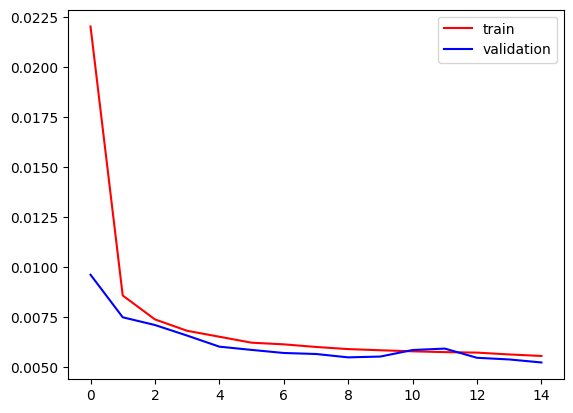

In [ ]:
plt.plot(history.history['loss'], color='red', label='train')
plt.plot(history.history['val_loss'], color='blue', label='validation')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 973ms/step


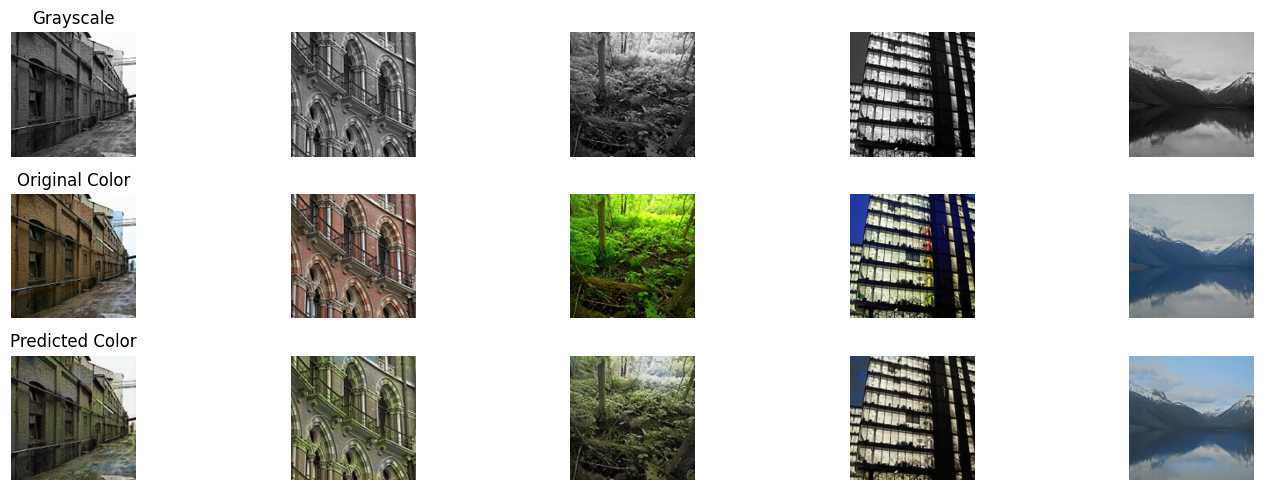

In [ ]:
# predictions
def show_predictions(dataset, model):
    gray_batch, color_batch = next(iter(dataset))
    preds = model.predict(gray_batch)

    plt.figure(figsize=(15, 5))
    for i in range(5):
        # Grayscale
        plt.subplot(3, 5, i + 1)
        plt.imshow(gray_batch[i].numpy().squeeze(), cmap='gray')
        plt.axis('off')
        if i == 0:
            plt.title("Grayscale")

        # Ground Truth
        plt.subplot(3, 5, i + 6)
        plt.imshow(color_batch[i].numpy())
        plt.axis('off')
        if i == 0:
            plt.title("Original Color")

        # Predicted Color
        plt.subplot(3, 5, i + 11)
        plt.imshow(preds[i])
        plt.axis('off')
        if i == 0:
            plt.title("Predicted Color")

    plt.tight_layout()
    plt.show()


show_predictions(test_ds, model)